In [1]:
colors = ColorData[97, "ColorList"];

In [6]:
d = Import["../data/purchase_times.csv"];
d = Sort[FromDateString /@ Flatten[d]];

In [8]:
d1 = FromDateString["2024-11-01 00:00:00.000"];
d2 = FromDateString["2024-11-02 00:00:00.000"];
d3 = FromDateString["2024-11-03 00:00:00.000"];
d4 = FromDateString["2024-11-04 00:00:00.000"];
d5 = FromDateString["2024-11-05 00:00:00.000"];
d6 = FromDateString["2024-11-06 00:00:00.000"];
d7 = FromDateString["2024-11-07 00:00:00.000"];
d8 = FromDateString["2024-11-08 00:00:00.000"];
d31 = FromDateString["2024-12-01 00:00:00.000"];

In [17]:
DateToReal[start_DateObject, date_DateObject] := N[2*Pi*QuantityMagnitude[DateDifference[d1,date], "Days"]]

In [18]:
dReal = Table[DateToReal[d1, i] ,{i, d}];
T = DateToReal[d1, d31];

In [28]:
jsonRep = {"N" -> Length[dReal], "T" -> T, "t" -> dReal};

In [37]:
Export["../data/purchase_times.json", jsonRep];

In [38]:
dfiltered1 = Select[d, d1 <= # < d2 &];
dfiltered7 = Select[d, d1 <= # < d8 &];

In [40]:
es = EventSeries[ {#, 1} & /@ d];
es1 = EventSeries[ {#, 1} & /@ dfiltered1];
es7 = EventSeries[ {#, 1} & /@ dfiltered7];

In [47]:
TimelinePlot[es1, PlotStyle->Tiny, PlotRange->{d1,d2}];

In [48]:
ListPlot[es7, 
  Filling->Axis, PlotRange -> {{d1, d8}, {0,1}},
  Ticks->{Automatic, None},
  PlotMarkers->" ", 
  Axes->{Automatic,None},
  Ticks->{{d1,d2,d3,d4,d5,d6,d7,d8}, Automatic}
  ];

In [57]:
ListPlot[es, Filling->Axis, PlotRange -> {{d1, d31}, {0,1}},
  Ticks->{Automatic, None}, PlotMarkers->" ", Axes->{Automatic,None}];

In [139]:
rateFun = α*Exp[Cos[t-φ]-1]^σ;

In [144]:
rateIntegral = Integrate[rateFun, {t, 0, 60*Pi}]

60 Pi α BesselI[0, σ]
---------------------
          σ
         E

In [72]:
stepData = es7["Dates"];
end = d8;
stepFunction  = TimeSeries[
    Append[Transpose[{Prepend[stepData, d1], Range[0, Length[stepData]]}], {end, Length[stepData]}]
];


In [75]:
stepPlot = DateListPlot[
    stepFunction,
    InterpolationOrder -> 0,
    PlotRange -> {{d1,d8}, Automatic},
    GridLines -> {True,False},
    PlotStyle -> Directive[AbsoluteThickness[1]],
    Frame -> True,
    Background -> None,
    FrameStyle -> Large,
    FrameTicks -> {{Automatic, None},  {{{d1, "Day 1"}, {d2, "Day 2"}, {d3, "Day 3"}, {d4, "Day 4"}, {d5, "Day 5"}, {d6, "Day 6"}, {d7, "Day 7"}, {d8, "Day 8"}}, None}},
    ImageSize -> 1024
];

In [84]:
Export["../images/step_plot_sales.png", stepPlot, Background->None];

In [85]:
{bins, countsD} = HistogramList[dReal, {0, 14*Pi, 2*Pi/24}];

-Graphics-
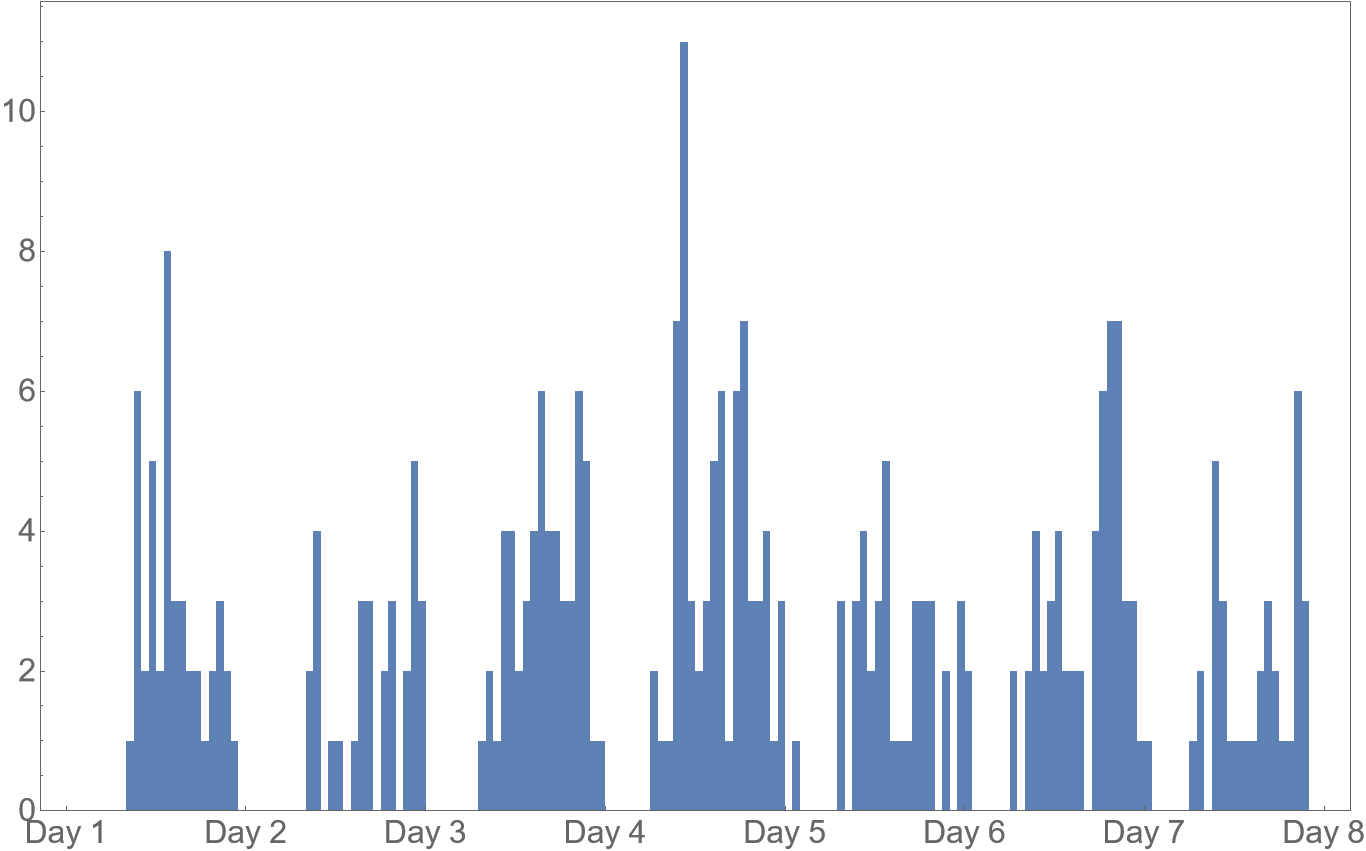

In [422]:
salesHourlyHistogram = DateHistogram[
    es7, "Hour", 
    PlotRange -> {{d1, d8}, Automatic},
    Frame -> True,
    Background -> None,
    ChartStyle -> colors[[1]],
    FrameTicks -> {{Automatic, None},  {{{d1, "Day 1"}, {d2, "Day 2"}, {d3, "Day 3"}, {d4, "Day 4"}, {d5, "Day 5"}, {d6, "Day 6"}, {d7, "Day 7"}, {d8, "Day 8"}}, None}},
    FrameStyle-> Large,
    ImageSize -> 1024
]

In [87]:
Export["../images/sales_hourly_histogram.png", salesHourlyHistogram, Background->None];

In [88]:
fitdata = Select[dReal, # < 14*Pi&]; 
n=Length[fitdata];
loglike = (
  σ Total[Cos[fitdata - φ]]
  + (Log[α]-σ) n 
  - α 14 Pi Exp[-σ] BesselI[0, σ]
  );

In [91]:
{crit, learnedParams} = NMaximize[{loglike, σ > 0 && α > 0 && -Pi < φ <= Pi}, {α, σ,φ}]

{379.774, {α -> 14.7926, σ -> 0.878421, φ -> -2.1888}}

In [224]:
likehomog = lambda^n*Exp[-lambda*14*Pi];
{crith, paramh} = NMaximize[{likehomog, lambda > 0}, lambda]

45
{9.32649 10  , {lambda -> 1.75667}}

In [160]:
rateFunP = rateFun /. learnedParams

-1 + Cos[2.1888 + t] 0.878421
14.7926 (E                    )

In [165]:
stepHour = 2*Pi/24;
stepMin = stepHour/60;
processCountsMin = Table[NIntegrate[rateFunP, {t, 0, x}], {x, 0, 14*Pi, stepMin}];
processCountsHour = Table[NIntegrate[rateFunP, {t, 0, x}], {x, 0, 14*Pi, stepHour}];

tsfit = TimeSeries[processCountsMin, {d1, d8}];


In [247]:
rateFunHomog = x/lambda*4*Pi /. paramh;
tshomog = TimeSeries[Table[rateFunHomog, {x, 0, 14*Pi, stepMin}], {d1, d8}];

In [253]:
countFit = Table[
    NIntegrate[rateFun /. learnedParams, {t, i*stepHour, (i+1)*stepHour}],
    {i, 0, 7*24-1}
];

-Graphics-
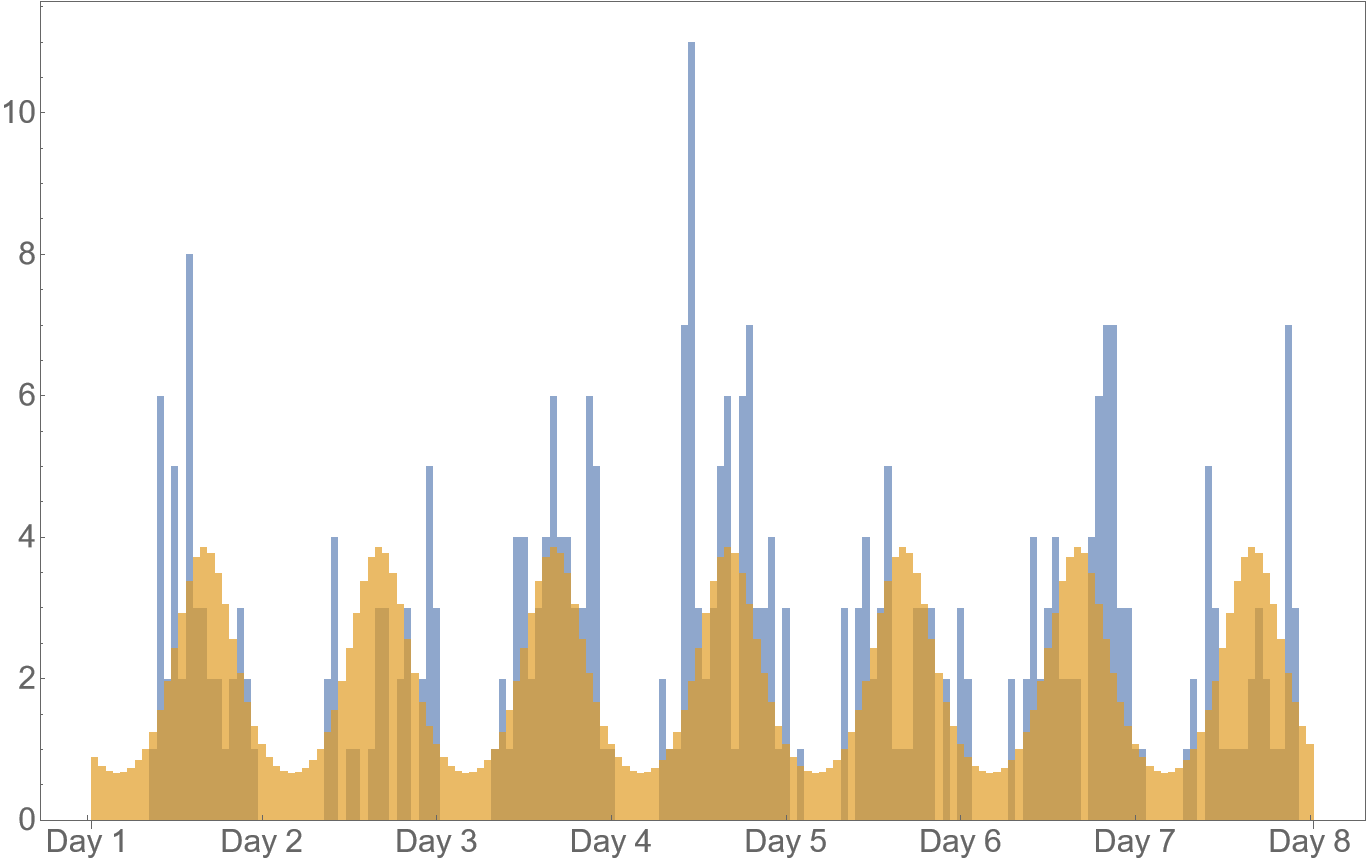

In [447]:
salesHourlyHistogram2 = Show[
    BarChart[countsD, ChartStyle -> Directive[colors[[1]], Opacity[0.7]],     Frame->True,
      FrameTicks -> {{Automatic, None},  {{{0, "Day 1"}, {24, "Day 2"}, {24*2, "Day 3"}, {24*3, "Day 4"}, {24*4, "Day 5"}, {24*5, "Day 6"}, {24*6, "Day 7"}, {24*7, "Day 8"}}, None}}
    ],
    BarChart[countFit, ChartStyle -> Directive[colors[[2]], Opacity[0.7]]],
    ImageSize -> 1024,
    FrameStyle -> Large
]

In [452]:
Export["../images/sales_hourly_histogram_fit.png", salesHourlyHistogram2, Background->None];

1
Legended[-Graphics-, Placed[LineLegend[{Directive[PointSize[---], AbsoluteThickness[1], 
                                                            360
 
>       RGBColor[0.560181, 0.691569, 0.194885]], 
 
                            1
>      Directive[PointSize[---], AbsoluteThickness[1], 
                           360
 
>       RGBColor[0.368417, 0.506779, 0.709798]], 
 
                            1
>      Directive[PointSize[---], AbsoluteThickness[1], 
                           360
 
>       RGBColor[0.880722, 0.611041, 0.142051]]}, {homogeneous fit, data, fit}, 
 
>     LegendMarkers -> {{False, Automatic}, {False, Automatic}, {False, Automatic}}, 
 
>     Joined -> {True, True, True}, LabelStyle -> {}, LegendLayout -> Row], Below, 
 
>    Identity]]
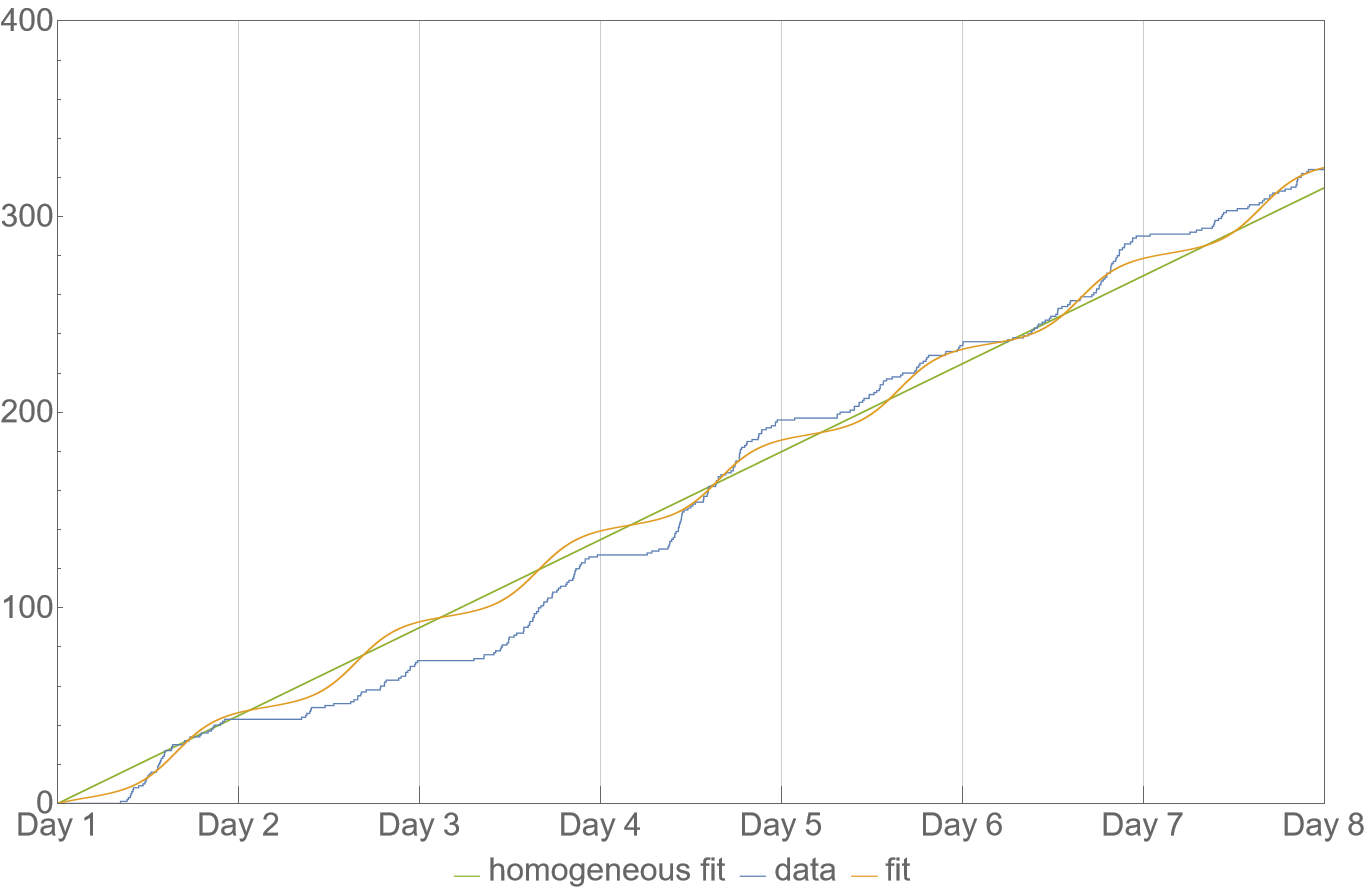

In [363]:
stepPlot2 = DateListPlot[
    {tshomog, stepFunction, tsfit},
    InterpolationOrder -> 0,
    PlotRange -> {{d1,d8}, {0,400}},
    GridLines -> {True,False},
    PlotStyle -> {{Directive[AbsoluteThickness[1]], colors[[3]]} , {Directive[AbsoluteThickness[1]], colors[[1]]}, {Directive[AbsoluteThickness[1]], colors[[2]]}},
    Frame -> True,
    Background -> None,
    FrameTicks -> {{Automatic, None},  {{{d1, "Day 1"}, {d2, "Day 2"}, {d3, "Day 3"}, {d4, "Day 4"}, {d5, "Day 5"}, {d6, "Day 6"}, {d7, "Day 7"}, {d8, "Day 8"}}, None}},
    PlotLegends -> Placed[{Style["homogeneous fit", Large, GrayLevel[0.4]], Style["data", Large, GrayLevel[0.4]], Style["fit", Large, GrayLevel[0.4]]}, Below],
    ImageSize -> 1024,
    FrameStyle -> Large
]

In [368]:
Export["../images/step_plot_sales_fit.png", stepPlot2, Background->None];

Directive[GrayLevel[0.5, 0.4]]

In [ ]:
Plot[rateFun /. {alpha ->1, phi->0, sigma -> -1.5}, {t, 0, 8*Pi}]

In [ ]:
params = {alpha ->1, phi->0, sigma -> 2-2I};
Plot[{Re[rateFun /. params],Im[rateFun /. params]}, {t, 0, 8*Pi}, PlotRange->{Automatic,Automatic}]

In [ ]:
Plot[{Abs[rateFun /. params],Arg[rateFun /. params]}, {t, 0, 8*Pi}, PlotRange->{Automatic,Automatic}]

1 + N                          1  1 + N  3 + N        2             2
  Cos[z]      Csc[z] Hypergeometric2F1[-, -----, -----, Cos[z] ] Sqrt[Sin[z] ]
                                       2    2      2
-(----------------------------------------------------------------------------)
                                     1 + N
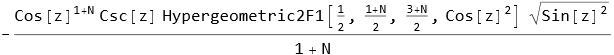

In [229]:
FullSimplify@Integrate[Cos[z]^N,z]

In [254]:
ClearAll[n, t, k, T,i];

Sum[Cos[phi - t ], {i, 1, n}]
               i
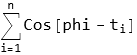

In [269]:
Sum[Cos[Subscript[t,i] - phi], {i, 1, n}]

T α BesselI[0, σ]
-(-----------------) + n (-σ + Log[α]) + σ Sum[Cos[ϕ - t ], {i, 1, n}]
          σ                                             i
         E
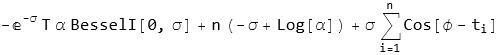

In [288]:
loglikeSym = \[Sigma]*Sum[Cos[Subscript[t,i] - \[Phi]], {i, 1, n}] + (Log[\[Alpha]]-\[Sigma])*n - \[Alpha]*T*Exp[-\[Sigma]]*BesselI[0, \[Sigma]]

σ Sum[-Sin[ϕ - t ], {i, 1, n}]
                i
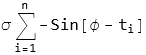

In [313]:
FullSimplify@D[loglikeSym,  \[Phi]]

T α (BesselI[0, σ] - BesselI[1, σ])
-n + ----------------------------------- + Sum[Cos[ϕ - t ], {i, 1, n}]
                      σ                                 i
                     E
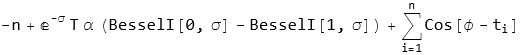

In [303]:
FullSimplify@D[loglikeSym,  \[Sigma]]

n   T BesselI[0, σ]
- - ---------------
α          σ
          E
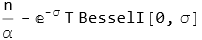

In [308]:
FullSimplify@D[loglikeSym,  \[Alpha]]

Reduce::nsmet: This system cannot be solved with the methods available to Reduce.

Reduce::nsmet: This system cannot be solved with the methods available to Reduce.

Reduce::nsmet: This system cannot be solved with the methods available to Reduce.

General::stop: Further output of Reduce::nsmet will be suppressed during this calculation.

Reduce[σ Sum[-Sin[ϕ - t ], {i, 1, n}] == 0 && 
                       i
 
          T α (BesselI[0, σ] - BesselI[1, σ])
>    -n + ----------------------------------- + Sum[Cos[ϕ - t ], {i, 1, n}] == 0 && 
                           σ                                 i
                          E
 
     n   T BesselI[0, σ]
>    - - --------------- == 0, {ϕ, σ, α}]
     α          σ
               E
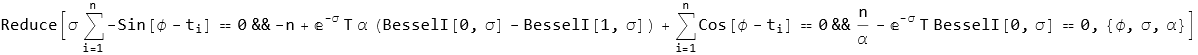

In [324]:
Reduce[D[loglikeSym,  \[Phi]] == 0 && FullSimplify@D[loglikeSym,  \[Sigma]] == 0 && FullSimplify@D[loglikeSym,  \[Alpha]] == 0, {\[Phi], \[Sigma],  \[Alpha]}]

σ
            E  n
{{α -> ---------------}}
       T BesselI[0, σ]
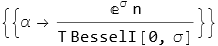

In [329]:
Solve[FullSimplify@D[loglikeSym,  \[Alpha]]==0, \[Alpha]]

σ
       E  (n - Sum[Cos[ϕ - t ], {i, 1, n}])
                            i
{{α -> ------------------------------------}}
        T (BesselI[0, σ] - BesselI[1, σ])
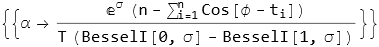

In [349]:
Solve[FullSimplify@D[loglikeSym,  \[Sigma]]==0, \[Alpha]]

In [354]:
rateFun

-1 + Cos[phi - t] sigma
alpha (E                 )

-Graphics-
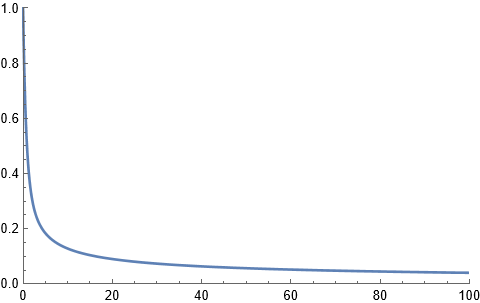

In [374]:
Plot[Exp[-t]*BesselI[0,t], {t, 0, 100}, PlotRange->{{0,100},{0,1}}]

In [389]:
Limit[Exp[-t]*BesselI[0,t], t->Infinity]

0

In [394]:
$ActivationKey

9796-6360-8L6VL9

In [399]:
$LicenseID

L9796-6360